In [69]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

import os
import glob

In [40]:
def load_local_data():
    csv_path = os.path.join(os.getcwd(), 'data/*.txt')
    # sort the files (by date stamp)
    all_files = sorted(glob.glob(csv_path))
    
    print 'reading data from files:'
    for f in all_files:
        print f
    print 'IMPORTANT NOTE: files in the folder must be consecutive! It is up to you to make sure there are not gaps.'
    
    data = pd.concat((pd.read_csv(f) for f in all_files))
    
    # strip whitespace off column headers (eg 'EXITS               ' has trailing spaces)
    data = data.rename(columns=lambda x: x.strip())
    return data

data = load_local_data()
print "\ngot %i rows total." % len(data)
data.head()

reading data from files:
/home/ian/metis/team_benson/data/turnstile_160319.txt
/home/ian/metis/team_benson/data/turnstile_160326.txt
/home/ian/metis/team_benson/data/turnstile_160402.txt
IMPORTANT NOTE: files in the folder must be consecutive! It is up to you to make sure there are not gaps.

got 578990 rows total.


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,03:00:00,REGULAR,5583673,1884949
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,07:00:00,REGULAR,5583689,1884968
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,11:00:00,REGULAR,5583785,1885067
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,15:00:00,REGULAR,5584037,1885157
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,19:00:00,REGULAR,5584482,1885250


In [41]:
# How many stations are there?
unique_stations = data.STATION.unique()
print len(unique_stations)

373


In [42]:
# make a datetime column
data['DATETIME'] = pd.to_datetime((data.DATE + ' ' + data.TIME), format="%m/%d/%Y %H:%M:%S")
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,03:00:00,REGULAR,5583673,1884949,2016-03-12 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,07:00:00,REGULAR,5583689,1884968,2016-03-12 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,11:00:00,REGULAR,5583785,1885067,2016-03-12 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,15:00:00,REGULAR,5584037,1885157,2016-03-12 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/12/2016,19:00:00,REGULAR,5584482,1885250,2016-03-12 19:00:00


In [43]:
# Sort data by DATETIME
# data.sort_values(by='DATETIME', inplace=True)
# data.head()

In [44]:
# Group by turnstile
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION'])

for diff_field in ('ENTRIES','EXITS'):
    data[diff_field + '_DIFF'] = turnstile_groupby[diff_field].transform(pd.Series.diff)


In [45]:
# sanity check for getting the differences:
nan_entries = len(data[data.ENTRIES_DIFF.isnull()])
total_unique_turnstiles = len(turnstile_groupby)
print 'the number of NaN entries should equal the total unique turnstiles.'
print nan_entries, total_unique_turnstiles

assert nan_entries == total_unique_turnstiles

the number of NaN entries should equal the total unique turnstiles.
4595 4595


## TODO
* Remove stations with negative ENTRIES_DIFF's


In [46]:
print 'negative entries:'
print len(data[(data.ENTRIES_DIFF < 0)])

# if you count NaN's
print len(data[~(data.ENTRIES_DIFF >= 0)])
# if you drop the NaN's first
print len(data.dropna()[~(data.dropna().ENTRIES_DIFF >= 0)])

negative entries:
3955
8550
3955


## Next, get the total station counts
To do this, groupby station and datetime, and sum the diffs across turnstiles

In [47]:
# group by station name and datetime,
station_time_groupby = data.groupby(['STATION','DATETIME','DATE','TIME'], as_index=False)

station_period_totals = station_time_groupby[['ENTRIES_DIFF', 'EXITS_DIFF']].sum()

def remove_suffix(col_name):
    first_underscore = col_name.find('_')
    if first_underscore != -1:
        return col_name[:first_underscore]
    return col_name

# rename the columns, dropping everything after and including the first underscore
station_period_totals.columns = [remove_suffix(column) for column in station_period_totals.columns]

# drop NaN
# station_period_totals.dropna(inplace=True)
station_period_totals.head()

,STATION,DATETIME,DATE,TIME,ENTRIES,EXITS
0,1 AV,2016-03-12 03:00:00,03/12/2016,03:00:00,NaN,NaN
1,1 AV,2016-03-12 07:00:00,03/12/2016,07:00:00,543,544
2,1 AV,2016-03-12 11:00:00,03/12/2016,11:00:00,2141,2070
3,1 AV,2016-03-12 15:00:00,03/12/2016,15:00:00,4508,2855
4,1 AV,2016-03-12 19:00:00,03/12/2016,19:00:00,5290,3598


## Try it Zhanna's way and see if you get the same result

In [48]:
# Zhanna: you could also group by station and datetime, sum the entries & exits, then do the diff.
# Use level=0 for MultiIndex on station.
# Since you aren't using turnstile-level data in the analysis, sum them and find the diffs to get the same result!

zhanna_station_groupby = data.drop(['ENTRIES_DIFF','EXITS_DIFF'], axis=1).groupby(['STATION','DATETIME'])
# summed cumulative entries and exits, per station
zhanna_station_groupby.sum().head()

ENTRIES       EXITS
STATION DATETIME                                   
1 AV    2016-03-12 03:00:00  1559766030  3475080175
        2016-03-12 07:00:00  1559766573  3475080719
        2016-03-12 11:00:00  1559768714  3475082789
        2016-03-12 15:00:00  1559773222  3475085644
        2016-03-12 19:00:00  1559778512  3475089242

In [49]:
# diff of summed cumulative entries
zhanna_station_counts_timeblock = zhanna_station_groupby.sum().diff()
zhanna_station_counts_timeblock.reset_index(inplace=True)
# zhanna_station_counts_timeblock.dropna(inplace=True)
zhanna_station_counts_timeblock.head()

,STATION,DATETIME,ENTRIES,EXITS
0,1 AV,2016-03-12 03:00:00,NaN,NaN
1,1 AV,2016-03-12 07:00:00,543,544
2,1 AV,2016-03-12 11:00:00,2141,2070
3,1 AV,2016-03-12 15:00:00,4508,2855
4,1 AV,2016-03-12 19:00:00,5290,3598


In [50]:
# these 675 are a difference in NaN rows which were dropped -- ie when I uncommented the .dropna lines above, 
# the difference in len was 675

len(zhanna_station_counts_timeblock['ENTRIES']) - len(station_period_totals['ENTRIES'])

0

In [51]:
zhanna_diff_df = pd.concat([
    zhanna_station_counts_timeblock.drop('EXITS', axis=1).rename(columns={'ENTRIES':'ENTRIES_ZH'}), 
    station_period_totals.ENTRIES], axis=1)
print len(zhanna_diff_df), len(station_period_totals)
assert len(zhanna_diff_df) == len(station_period_totals)
zhanna_diff_df.head()

83772 83772


,STATION,DATETIME,ENTRIES_ZH,ENTRIES
0,1 AV,2016-03-12 03:00:00,NaN,NaN
1,1 AV,2016-03-12 07:00:00,543,543
2,1 AV,2016-03-12 11:00:00,2141,2141
3,1 AV,2016-03-12 15:00:00,4508,4508
4,1 AV,2016-03-12 19:00:00,5290,5290


In [52]:
zhanna_diff_df[zhanna_diff_df.ENTRIES != zhanna_diff_df.ENTRIES_ZH].head()

,STATION,DATETIME,ENTRIES_ZH,ENTRIES
0,1 AV,2016-03-12 03:00:00,NaN,NaN
116,1 AV,2016-03-31 09:25:33,-442454561,451
117,1 AV,2016-03-31 12:00:00,442460148,5136
126,103 ST,2016-03-12 00:00:00,-1408495191,NaN
141,103 ST,2016-03-14 10:22:21,-89483544,1030


In [53]:
zhanna_diff_df.describe()

,ENTRIES_ZH,ENTRIES
count,8.377100e+04,8.309600e+04
mean,-1.797877e+04,2.250278e+04
std,5.730463e+08,6.390402e+06
min,-7.429105e+09,-2.348442e+08
25%,-1.386600e+04,3.700000e+01
50%,7.820000e+02,2.900000e+02
75%,1.697400e+04,1.228000e+03
max,7.264182e+09,1.771416e+09


In [54]:
print 'Negative ENTRIES with zhanna groupby.diff vs my transform(pd.Series.diff)'
print len(zhanna_diff_df[zhanna_diff_df.ENTRIES_ZH < 0])
print len(zhanna_diff_df[zhanna_diff_df.ENTRIES < 0])

Negative ENTRIES with zhanna groupby.diff vs my transform(pd.Series.diff)
22470
86


## --> RESULTS of `diff` methods comparison
The "zhanna way" has less NaN's, and it looks like those NaN's are replaced with many, many big negative numbers. 
Maybe this is due to a buggy behavior in `groupby.diff` ???

Or maybe it's because of non-REGULAR entries?

I still don't understand it, but I think mine is safer...



## Clean up: Remove NaN's and negative ENTRIES from station_period_totals

In [55]:
pre_cleanup_len = len(station_period_totals)

station_period_totals = station_period_totals[station_period_totals.ENTRIES >= 0]

print 'got rid of %i rows' % (pre_cleanup_len - len(station_period_totals))

got rid of 762 rows


## Daily totals per station

In [56]:
daily_station_totals = station_period_totals.drop('DATETIME', axis=1).groupby(['STATION','DATE'], as_index=False).sum()
daily_station_totals.head()

,STATION,DATE,ENTRIES,EXITS
0,1 AV,03/12/2016,17542,12265
1,1 AV,03/13/2016,12724,9090
2,1 AV,03/14/2016,22301,14618
3,1 AV,03/15/2016,23331,14377
4,1 AV,03/16/2016,24622,14891


In [57]:
# find top stations for ENTRIES on date of interest
date_of_interest = '03/20/2016'
top_daily_entries = daily_station_totals[daily_station_totals['DATE'] == date_of_interest].sort_values(by='ENTRIES', ascending=False).head(10)
top_daily_entries

,STATION,DATE,ENTRIES,EXITS
6172,NEWARK BM BW,03/20/2016,148779,20242
1287,34 ST-PENN STA,03/20/2016,78156,71125
302,14 ST-UNION SQ,03/20/2016,73319,62526
7302,TIMES SQ-42 ST,03/20/2016,60173,59259
2295,86 ST,03/20/2016,57284,52600
1245,34 ST-HERALD SQ,03/20/2016,55698,55579
1434,42 ST-PORT AUTH,03/20/2016,53454,41323
974,23 ST,03/20/2016,48543,39611
4808,GRD CNTRL-42 ST,03/20/2016,44287,42873
3553,CANAL ST,03/20/2016,40117,29592


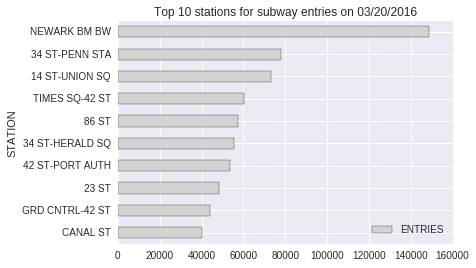

In [65]:
# for some reason you have to make ascending=True to make barh in descending order...
top_daily_entries.sort_values(by='ENTRIES', ascending=True).plot.barh(x='STATION', 
    y='ENTRIES', 
    title='Top 10 stations for subway entries on %s' % date_of_interest,
    color='lightgrey',
    legend=True)

# TODO
* Do that same graph, but for the month that Lucia did

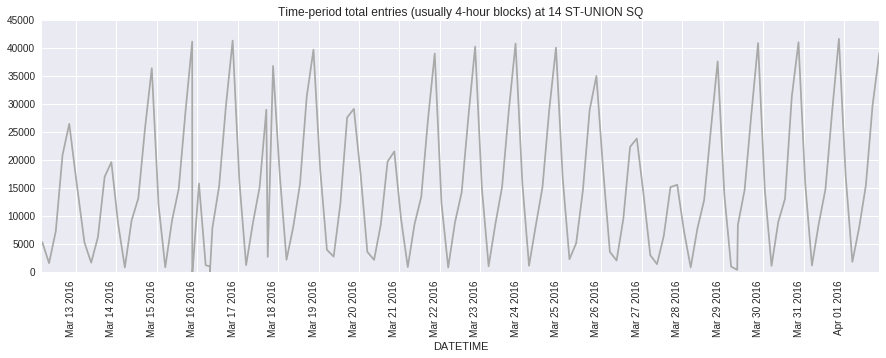

In [88]:
station_of_interest = '14 ST-UNION SQ'

fig, ax = plt.subplots(figsize=[15,5])

station_period_totals[station_period_totals['STATION'] == station_of_interest][['DATETIME','ENTRIES']].plot(
    title='Time-period total entries (usually 4-hour blocks) at %s' % station_of_interest,
    x='DATETIME',
    y='ENTRIES',
    legend=False,
    color='darkgrey',
    rot=90,
    ax=ax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# TODO
* Make sure the selected time period is all **REGULAR**

## Heatmap, average entries over 2 month period for single station of interest.
Time of day x day of week

In [60]:
station_of_interest = 'TIMES SQ-42 ST'

print 'for %s' % station_of_interest
station_entries_data = station_period_totals[station_period_totals.STATION == station_of_interest][
    ['DATE','TIME','DATETIME','ENTRIES']]

station_entries_data.head()

for TIMES SQ-42 ST


,DATE,TIME,DATETIME,ENTRIES
79232,03/12/2016,07:00:00,2016-03-12 07:00:00,1764
79233,03/12/2016,11:00:00,2016-03-12 11:00:00,5697
79234,03/12/2016,15:00:00,2016-03-12 15:00:00,11660
79235,03/12/2016,19:00:00,2016-03-12 19:00:00,20360
79236,03/12/2016,23:00:00,2016-03-12 23:00:00,18524


In [61]:
station_pivot = station_entries_data.pivot('TIME','DATE','ENTRIES')
station_pivot

# drop NaN's (within threshold). Ideally you would add to the nearest bracket
station_pivot.dropna(axis=0, inplace=True, thresh=2)
station_pivot

DATE,03/12/2016,03/13/2016,03/14/2016,03/15/2016,03/16/2016,03/17/2016,03/18/2016,03/19/2016,03/20/2016,03/21/2016,...,03/23/2016,03/24/2016,03/25/2016,03/26/2016,03/27/2016,03/28/2016,03/29/2016,03/30/2016,03/31/2016,04/01/2016
TIME,,,,,,,,,,,,,,,,,,,,,
00:00:00,NaN,NaN,11994,13479,19139,19491,20517,19885,17703,11023,...,18676,19935,21578,22427,19947,13364,14832,17847,18867,20247
04:00:00,NaN,10172,2523,2651,3564,3613,4522,6267,6022,1977,...,3158,3854,4763,7081,6781,2970,2682,2615,3176,3588
08:00:00,NaN,2280,4542,4851,4083,4908,4640,1891,1720,4631,...,4896,4824,3696,1848,1484,4184,4806,4643,5059,4567
12:00:00,NaN,5063,8053,13614,11903,12040,13325,7024,9665,12799,...,13457,9386,11108,7518,5284,10344,13516,13987,14450,12881
16:00:00,NaN,10056,13986,16250,17005,18439,18653,12828,9798,15440,...,17288,17919,19876,12724,9977,15061,17257,17111,17212,17977
20:00:00,NaN,16565,39736,40245,42348,41941,39415,19709,15265,40268,...,42212,40871,31345,20949,17783,38792,40933,41799,40433,38128


14 ST-UNION SQ


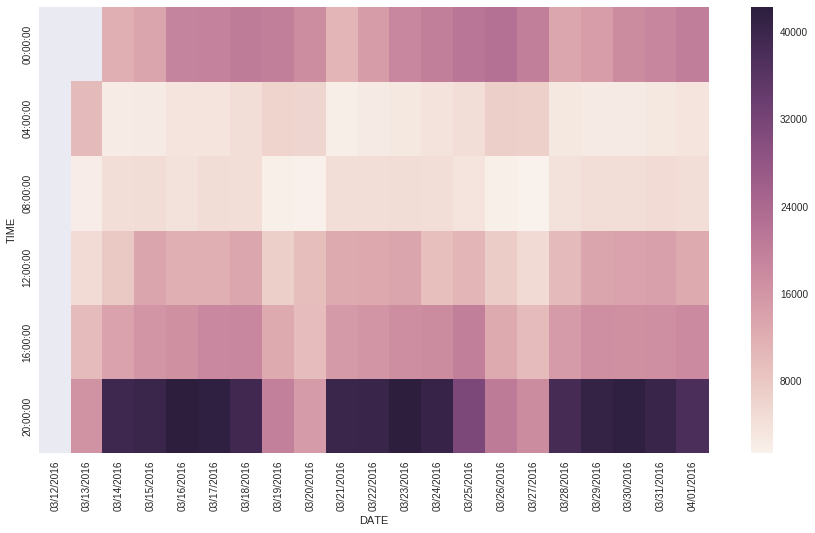

In [91]:
print station_of_interest

fig, ax = plt.subplots(figsize=[15,8])
sns.heatmap(station_pivot, ax=ax)